In [3]:
import pandas
import matplotlib.pyplot as plt

pandas.set_option('display.max_columns', 10)
pandas.set_option('display.width', 350)
  
#read from google drive
data=pandas.read_csv("s3://full-stack-bigdata-datasets/Machine Learning Supervisé/Projet Conversion Rate/conversion_data.csv")
  
print(data.head())

  country  age  new_user source  total_pages_visited  converted
0      UK   25         1    Ads                    1          0
1      US   23         1    Seo                    5          0
2      US   28         1    Seo                    4          0
3   China   39         1    Seo                    5          0
4      US   30         1    Seo                    6          0



# Descriptive Statistics

Firstly, let’s inspect the data to look for weird behavior/wrong data. Data is never perfect in real life and requires to be cleaned. Identifying the wrong data and dealing with it is a crucial step

Describe and groupby are usually the best places to start: 

In [4]:
print(data.describe())

                 age       new_user  total_pages_visited      converted
count  316200.000000  316200.000000        316200.000000  316200.000000
mean       30.569858       0.685465             4.872966       0.032258
std         8.271802       0.464331             3.341104       0.176685
min        17.000000       0.000000             1.000000       0.000000
25%        24.000000       0.000000             2.000000       0.000000
50%        30.000000       1.000000             4.000000       0.000000
75%        36.000000       1.000000             7.000000       0.000000
max       123.000000       1.000000            29.000000       1.000000


In [5]:
print(data.groupby(['country']).size())

country
China       76602
Germany     13056
UK          48450
US         178092
dtype: int64


In [6]:
print(data.groupby(['source']).size())

source
Ads        88740
Direct     72420
Seo       155040
dtype: int64


A few quick observations:

* the site is probably a US site, although it does have a large Chinese user base as well

* user base is pretty young

* conversion rate at around 3% is industry standard. It makes sense. Beware ! It means that we're working with an imbalanced dataset !

* everything seems to make sense here except for max age 123 yrs! Let’s investigate it: 

In [7]:
print(sorted(data['age'].unique(), reverse=True))

[123, 111, 79, 77, 73, 72, 70, 69, 68, 67, 66, 65, 64, 63, 62, 61, 60, 59, 58, 57, 56, 55, 54, 53, 52, 51, 50, 49, 48, 47, 46, 45, 44, 43, 42, 41, 40, 39, 38, 37, 36, 35, 34, 33, 32, 31, 30, 29, 28, 27, 26, 25, 24, 23, 22, 21, 20, 19, 18, 17]


Those 123 and 111 values seem unrealistic. How many users are we talking about:

In [8]:
print(data[data['age']>110])

        country  age  new_user source  total_pages_visited  converted
90928   Germany  123         0    Seo                   15          1
295581       UK  111         0    Ads                   10          1


It is just 2 users! In this case, we can remove them, nothing will change. In general, depending on the problem, you can:

remove the entire row saying you don’t trust the data

treat them as NAs

if there is a pattern, try to figure out what went wrong.

That being said, wrong data is worrisome and can be an indicator of some bug in the logging code. Therefore, when working, you will want to talk to the software engineer who implemented the logging code to see if, perhaps, there are some bugs which affect the data significantly.

Here, let’s just get rid of those two rows:

In [9]:
data = data[data['age']<110]

Now, let’s quickly investigate the variables and how their distribution differs for the two classes. This will help us understand whether there is any information in our data in the first place and get a sense of the data.

Never start by blindly building a machine learning model. Always first get a sense of the data 

Let’s just pick a couple of variables as example, but you should do it with all:



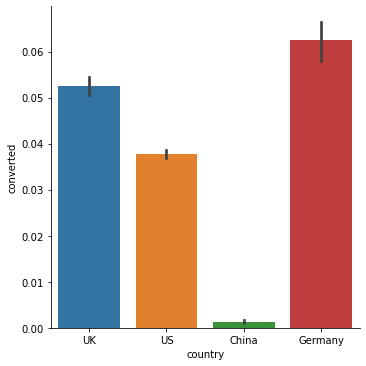

In [10]:
import seaborn as sns 
sns.catplot(x="country", y="converted", data=data, kind="bar")

Here it clearly looks like Chinese convert at a much lower rate than other countries! 

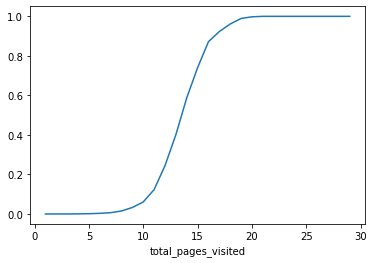

In [11]:
data.groupby(['total_pages_visited'])['converted'].mean().plot()
plt.show()

Definitely spending more time on the site implies higher probability of conversion!

## Machine Learning


Let’s now build a model to predict conversion rate. Outcome is binary and you care about insights to give product and marketing team project ideas. You should probably choose among the following options:

Logistic regression

Decision Trees

RuleFit

Random Forest or Boosted Decision Trees in combination with partial dependence plots

It is good to add two lines to explain why you chose a given approach.

Ex: I am going to pick a random forest to predict conversion rate. I picked a random forest because: it usually requires very little time to optimize it (its default params are often close to be the best ones) and it is strong with outliers, irrelevant variables, continuous and discrete variables. I will use the random forest to predict conversion, then I will use its partial dependence plots and variable importance to get insights. Also, I will build a simple tree to find the most obvious user segments. 

In [10]:
#dummy variables for the categorical ones
#data_dummy = pandas.get_dummies(data, drop_first=True)

Create test/training set with a standard 66% split and make some preprocessings

In [23]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import  OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.model_selection import train_test_split

In [15]:
data.head()

,country,age,new_user,source,total_pages_visited,converted
0,UK,25,1,Ads,1,0
1,US,23,1,Seo,5,0
2,US,28,1,Seo,4,0
3,China,39,1,Seo,5,0
4,US,30,1,Seo,6,0


In [26]:
# separate target Y from variables X
X = data.iloc[:,:-1]
Y = data.iloc[:,-1]

X = X.values
Y = Y.tolist()
  
#split into train and test to avoid overfitting
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.34, random_state = 0)

# Create pipeline for numeric features
numeric_features = [1,2,4] # Positions of numeric columns in X_train/X_test
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# Create pipeline for categorical features
categorical_features = [0,3] # Positions of categorical columns in X_train/X_test
categorical_transformer = Pipeline(
    steps=[
    ('encoder', OneHotEncoder(drop='first')) # first column will be dropped to avoid creating correlations between features
    ])

# Use ColumnTransformer to make a preprocessor object that describes all the treatments to be done
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Preprocessings on train set
print("Performing preprocessings on train set...")
print(X_train[0:5,:])
X_train = preprocessor.fit_transform(X_train)
print('...Done.')
print(X_train[0:5,:])
print()

# Preprocessings on test set
print("Performing preprocessings on test set...")
print(X_test[0:5,:])
X_test = preprocessor.transform(X_test) # Don't fit again !! 
print('...Done.')
print(X_test[0:5,:])
print()

  
#build the model
lr = LogisticRegression()
lr.fit(X_train, Y_train)
  
#let's print test accuracy and confusion matrix

print(
"train accuracy is", 
lr.score(X_train, Y_train), 
"\n", 
"train f1-score is", 
f1_score(Y_train, lr.predict(X_train)), 
"\n",
"train Confusion Matrix", 
"\n",
pandas.DataFrame(confusion_matrix(Y_train, lr.predict(X_train), labels=[0, 1]))
)

print('----------')

print(
"test accuracy is", 
lr.score(X_test, Y_test), 
"\n", 
"test f1-score is", 
f1_score(Y_test, lr.predict(X_test)), 
"\n",
"test Confusion Matrix", 
"\n",
pandas.DataFrame(confusion_matrix(Y_test, lr.predict(X_test), labels=[0, 1]))
)

Performing preprocessings on train set...
[['US' 27 0 'Ads' 4]
 ['US' 30 1 'Seo' 3]
 ['China' 34 1 'Ads' 3]
 ['US' 51 1 'Seo' 6]
 ['US' 30 1 'Seo' 1]]
...Done.
[[-0.43010463 -1.47646239 -0.26099754  0.          0.          1.
   0.          0.        ]
 [-0.06686318  0.6772946  -0.5599365   0.          0.          1.
   0.          1.        ]
 [ 0.41745874  0.6772946  -0.5599365   0.          0.          0.
   0.          0.        ]
 [ 2.47582691  0.6772946   0.33688039  0.          0.          1.
   0.          1.        ]
 [-0.06686318  0.6772946  -1.15781443  0.          0.          1.
   0.          1.        ]]

Performing preprocessings on test set...
[['US' 24 0 'Ads' 2]
 ['US' 20 1 'Direct' 6]
 ['US' 43 1 'Ads' 10]
 ['China' 35 0 'Direct' 3]
 ['US' 25 0 'Direct' 2]]
...Done.
[[-0.79334607 -1.47646239 -0.85887546  0.          0.          1.
   0.          0.        ]
 [-1.27766799  0.6772946   0.33688039  0.          0.          1.
   1.          0.        ]
 [ 1.50718307  0.6